In [85]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from src.vimlts_fast import VimltsLinear
%load_ext autoreload
%autoreload 2
sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We define the prior as a Beta distribution and the coresponding likelihood
is the Bernoulli distribution -> Posterior is a Beta-distribution too.

Likelihood: $$y \thicksim Bernoulli(\theta)$$

Prior: $$ \theta \thicksim  Beta(\alpha, \beta) $$

Posterior: $$p(\theta | y) = \frac{p(y| \theta) \cdot p(\theta)}{p(y)}$$

==> In this case the posterior is known because of the conjugate prior

==> Posterior is a Beta distribution too. Parameters:

$$p(\theta|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$


Prior:
$p(\theta) \thicksim Beta(\alpha=0.5, \beta=5.)$

Text(0.5, 1.0, 'Prior p(\\theta)')

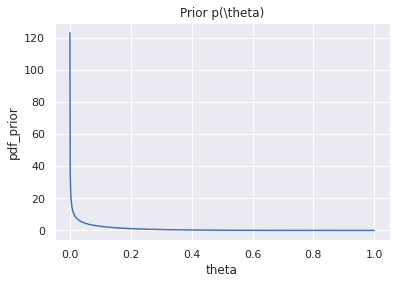

In [86]:
thetas = np.linspace(0.0001, .9999, 1000)
alpha = .5
beta = 5.
pdf_prior = stats.beta(a=alpha, b=beta).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_prior=pdf_prior, theta=thetas)), x='theta', y='pdf_prior')
plt.title("Prior p(\\theta)")

Likelihood

(array([8., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

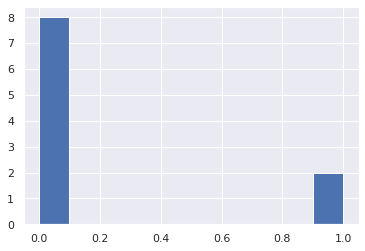

In [87]:
np.random.seed(3)
data = stats.bernoulli(p=0.25).rvs(size=10)
plt.hist(data)

Text(0.5, 1.0, 'Likelihood p(y|\\theta)')

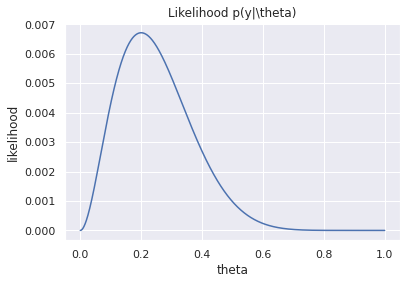

In [88]:
log_likelihood = [stats.bernoulli(p=theta).logpmf(data).sum() for theta in thetas]
likelihood = np.exp(log_likelihood)
sns.lineplot(data=pd.DataFrame.from_dict(dict(likelihood=likelihood, theta=thetas)), x='theta', y='likelihood')
plt.title("Likelihood p(y|\\theta)")

Posterior analytic

$$p(\theta|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$

integral of pdf:  0.9999992257045808


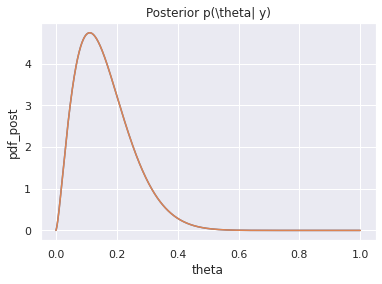

In [89]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_post=pdf_post, theta=thetas)), x='theta', y='pdf_post')
plt.plot(thetas, likelihood*pdf_prior/np.trapz(likelihood*pdf_prior, thetas), linestyle='solid')
plt.title("Posterior p(\\theta| y)")
print("integral of pdf: ", np.trapz(pdf_post, thetas))

like * prior same as analytic known posterior distribution

Now use VIMLTs to approximate posterior distribution


## MFVI

### Functions

In [90]:
# Convenience function to write out weights
class Logger:
    """
        Writes out the weights, gradient, and losses.
    """
    def __init__(self, steps, num_weights = 4):
        self.steps = steps
        self.num_weights = num_weights
        self.X = np.zeros((steps,(4+2*num_weights)))

    def log(self, step, epoch, lambda_tunable, lambda_tunable_grad, loss, loss_kl, loss_nll):
        n = self.num_weights
        self.X[step,0] = epoch
        self.X[step,1:(n+1)] = lambda_tunable.numpy()
        self.X[step,(n+1):((2*n)+1)] = lambda_tunable_grad.numpy()
        self.X[step,((2*n)+1)] = loss.numpy()
        self.X[step,((2*n)+2)] = loss_kl.numpy()
        self.X[step,((2*n)+3)] = loss_nll.numpy()

    def getX(self):
        return self.X

In [91]:
def kl_divergence(q, p):
    """
        Calculates the kl divergence.
    """
    # Avoid numerical problems
    mask = ((q > 1e-08) | (p > 1e-08)) & (np.isinf(q)==0) & (np.isinf(p)==0)
    return tf.math.reduce_sum(tf.where(mask, tf.math.log(q/p), 0))

In [92]:
def get_lr(current_epoch):
    """
        Returns the learning rate depending to the current epoch.
    """
    lr_dyn=(epochs-current_epoch)/epochs
    return lr_start*lr_dyn+lr_end*(1-lr_dyn)

### Create a model

In [93]:
import tensorflow as tf
import tensorflow_probability as tfp
from src.vimlts import VIMLTS
from tensorflow_probability import distributions as tfd
from tqdm import tqdm
from scipy.stats import norm
log=tf.math.log

In [94]:
# Number of epochs
epochs=10

# Number of samples psi to approximate the expected value
num_samples=10

# Learning rate
lr_start=0.1
lr_end=0.1

# Variational parameters init
a_init=(0.2,)
b_init=(0.,)
alpha_init = (np.log(np.exp(0.2) -1),)
beta_init = (0,)
# List to save the variational distribution during training
q_history=[]

# Prior
prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta)

ytensor = data.reshape(-1, 1)

In [95]:
tf.random.set_seed(1)
np.random.seed(1)

ans=5
if(ans==6):
    # Using a high slope will help to find a mode that creates a bimodal fit
    delta_theta_high_slope_init = (-6,2.,-6.,-6.,-6.,8.,-6.,-6.,-6,3.)
    delta_theta_init=delta_theta_high_slope_init
else:
    delta_theta_gaussian_like_init = (-5,1.,0.8,0.8,0.6,0.4,0.2,0.2,1.,.0)
    delta_theta_init=delta_theta_gaussian_like_init

lambda_init=a_init+b_init+delta_theta_init+alpha_init+beta_init
num_lambda=np.shape(lambda_init)[0]
lambda_tunable = tf.Variable(lambda_init,dtype='float32')
# Instance of a variational distribution as VIMLTS
q_dist=VIMLTS(np.shape(delta_theta_init)[0])
# Update the variational parameter to the variational distribution
q_dist.update_lambda_param(lambda_tunable)

# Save the distribution to the history
q_history.append(q_dist.get_target_dist(num=1000))

# Logging
logger = Logger(epochs,num_weights=num_lambda)

No handles with labels found to put in legend.


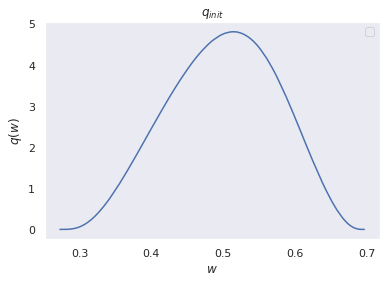

In [96]:
for hist in q_history:
    w = tf.math.sigmoid(hist[1]).numpy()
    p = hist[0].numpy()
    p /= np.trapz(p, w)
    plt.plot(w, p)
plt.legend()
plt.grid()
plt.title(r'$q_{init}$')
plt.ylabel(r'$q(w)$')
plt.xlabel(r'$w$');

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
YES activation is Bijector
Model: "vimlts_linear"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_14 (VimltsLine multiple                  14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


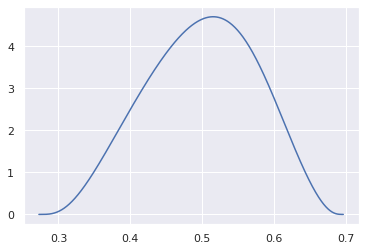

In [97]:
layer = VimltsLinear(1,
                     activation=tfp.bijectors.Sigmoid(low=1e-9, high=1.-1e-9),
                     alpha_w=alpha_init[0],
                     beta_w=beta_init[0],
                     alpha_z=a_init[0],
                     beta_z=b_init[0],
                     theta=delta_theta_init,
                     num_samples=5,
                     prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta))
model = tf.keras.models.Sequential(layer, name='vimlts_linear')
model.build(input_shape=(None,1))
model.summary()

q, w = layer.get_w_dist(num=1000)
q = q.squeeze()
w = w.squeeze()
bij = tfp.bijectors.Sigmoid()
pi = bij(w)
q_pi = tf.math.log(q) + bij.inverse_log_det_jacobian(pi, event_ndims=0)

plt.plot(pi, tf.math.exp(q_pi), label="VIMLTS")


In [35]:
from IPython.display import display, clear_output, HTML
tf.random.set_seed(1)
q_dist=VIMLTS(np.shape(delta_theta_init)[0])
# Update the variational parameter to the variational distribution
q_dist.update_lambda_param(lambda_tunable)
for i in tqdm(range(10)):
    with tf.GradientTape() as tape:
        tape.watch([lambda_tunable])

        # Parameter update --------------------------------------------------
        q_dist.update_lambda_param(lambda_tunable)

        # Iterarte over psi (number of samples)
        for current_sample in range(num_samples):
            # l_nll ------------------------------------------
            z_sample,w_sample_r=q_dist.get_sample_w()
            sigmoid_bij = tfp.bijectors.Sigmoid()
            w_sample = sigmoid_bij.forward(w_sample_r)
            assert np.isclose(w_sample, tf.math.sigmoid(w_sample_r)), "w sample should be the same"
            # Likelihood
            w_sample = tf.clip_by_value(w_sample, 1e-6, 1.-1e-6)
            # print("w_sample: ", w_sample)
            y_prob = tfd.Bernoulli(probs=w_sample)
            # print("y_prob: ", y_prob)
            # print("ytensor: ", ytensor)
            # print("y_prob log_prob: ", y_prob.log_prob(ytensor))
            # loss_nll
            l_nll_sample=-tf.reduce_sum(y_prob.log_prob(ytensor))
            l_nll_sample=tf.reshape(l_nll_sample,[-1])
            if current_sample==0:
                l_nll_list = l_nll_sample
            else:
                l_nll_list= tf.concat([l_nll_list, tf.reshape(l_nll_sample,[-1])],axis=0)


        # l_kl ------------------------------------------
            variational_dist_sample, _= q_dist.get_target_dist_for_z(z_sample)
            variational_dist_sample *= tf.math.abs((1+tf.math.exp(-w_sample_r))**2 / tf.exp(-w_sample_r))
            prior_sample=prior_dist.prob(w_sample)
            # print("z sample", z_sample)
            # print("test2: ", prior_sample)
            # print("variational_dist_sample: ", variational_dist_sample)
            l_kl_sample=kl_divergence(variational_dist_sample,prior_sample)
            l_kl_sample=tf.reshape(l_kl_sample,[-1])
            if current_sample==0:
                l_kl_list = l_kl_sample
            else:
                l_kl_list= tf.concat([l_kl_list,l_kl_sample],axis=0)


        l_nll=tf.reduce_mean(l_nll_list,axis=0)
        print("l_nll: ", l_nll)
        l_kl=tf.reduce_mean(l_kl_list,axis=0)
        print("l_kl: ", l_kl)

        # loss --------------------------------------
        loss = l_nll + l_kl

    grads = tape.gradient(loss,lambda_tunable)

    # Check for NaNs in gradient
    if True in tf.math.is_nan(grads):
        print("+++++++++NaN in gradient+++++++++++++")
        print("Parameter:", w_sample.numpy())
        print("Grads:",grads)
        continue

    # Save epoche to logger
    logger.log(i, i, lambda_tunable, grads, loss, l_kl, l_nll)

    # Update the variational parameter
    lr=get_lr(i)
    lambda_tunable = tf.Variable(lambda_tunable - lr*grads)


    # Prints and history
    if i % 10 == 0 or i < 10 or i==epochs-1:
        # clear_output()
        print("\tloss \t", loss.numpy(),"\tl_nll\t",l_nll.numpy(),"\tl_kl\t",l_kl.numpy(), "\tlr ", lr)
        save_history=True
        if(save_history):
            q_history.append(q_dist.get_target_dist())

  0%|          | 0/10 [00:00<?, ?it/s]

l_nll:  tf.Tensor(7.039958, shape=(), dtype=float32)
l_kl:  tf.Tensor(3.5275922, shape=(), dtype=float32)
	loss 	 10.567551 	l_nll	 7.039958 	l_kl	 3.5275922 	lr  0.1


 10%|█         | 1/10 [00:02<00:25,  2.78s/it]

l_nll:  tf.Tensor(5.5911717, shape=(), dtype=float32)
l_kl:  tf.Tensor(1.7662535, shape=(), dtype=float32)
	loss 	 7.357425 	l_nll	 5.5911717 	l_kl	 1.7662535 	lr  0.1


 20%|██        | 2/10 [00:05<00:20,  2.58s/it]

l_nll:  tf.Tensor(5.2497106, shape=(), dtype=float32)
l_kl:  tf.Tensor(1.8762964, shape=(), dtype=float32)
	loss 	 7.126007 	l_nll	 5.2497106 	l_kl	 1.8762964 	lr  0.1


 30%|███       | 3/10 [00:07<00:17,  2.57s/it]

l_nll:  tf.Tensor(5.2404013, shape=(), dtype=float32)
l_kl:  tf.Tensor(1.3634279, shape=(), dtype=float32)
	loss 	 6.6038294 	l_nll	 5.2404013 	l_kl	 1.3634279 	lr  0.1


 40%|████      | 4/10 [00:10<00:15,  2.52s/it]

l_nll:  tf.Tensor(5.1350365, shape=(), dtype=float32)
l_kl:  tf.Tensor(1.2536074, shape=(), dtype=float32)
	loss 	 6.3886437 	l_nll	 5.1350365 	l_kl	 1.2536074 	lr  0.1


 50%|█████     | 5/10 [00:12<00:12,  2.49s/it]

l_nll:  tf.Tensor(5.1125956, shape=(), dtype=float32)
l_kl:  tf.Tensor(1.2784551, shape=(), dtype=float32)
	loss 	 6.391051 	l_nll	 5.1125956 	l_kl	 1.2784551 	lr  0.1


 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

l_nll:  tf.Tensor(5.2371116, shape=(), dtype=float32)
l_kl:  tf.Tensor(0.7581526, shape=(), dtype=float32)
	loss 	 5.995264 	l_nll	 5.2371116 	l_kl	 0.7581526 	lr  0.1


 70%|███████   | 7/10 [00:17<00:07,  2.49s/it]

l_nll:  tf.Tensor(5.1768003, shape=(), dtype=float32)
l_kl:  tf.Tensor(1.0943851, shape=(), dtype=float32)
	loss 	 6.2711854 	l_nll	 5.1768003 	l_kl	 1.0943851 	lr  0.09999999999999999


 80%|████████  | 8/10 [00:20<00:04,  2.47s/it]

l_nll:  tf.Tensor(5.269883, shape=(), dtype=float32)
l_kl:  tf.Tensor(0.90325844, shape=(), dtype=float32)
	loss 	 6.1731415 	l_nll	 5.269883 	l_kl	 0.90325844 	lr  0.10000000000000002


 90%|█████████ | 9/10 [00:22<00:02,  2.50s/it]

l_nll:  tf.Tensor(5.3036523, shape=(), dtype=float32)
l_kl:  tf.Tensor(0.864168, shape=(), dtype=float32)
	loss 	 6.1678205 	l_nll	 5.3036523 	l_kl	 0.864168 	lr  0.1


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


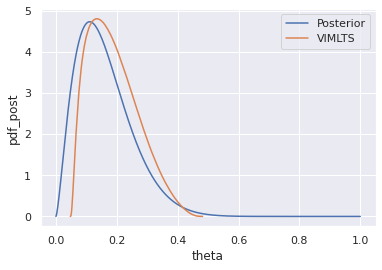

In [36]:
q, w = q_dist.get_target_dist()
w = tf.math.sigmoid(w)
q = q / np.trapz(q, x=w) # normalize

alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_post=pdf_post, theta=thetas)), x='theta', y='pdf_post', label="Posterior")
plt.plot(w,q, label="VIMLTS")
plt.legend()

# Compare with VIMLT fast

YES activation is Bijector
Model: "vimlts_linear"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_40 (VimltsLine multiple                  54        
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


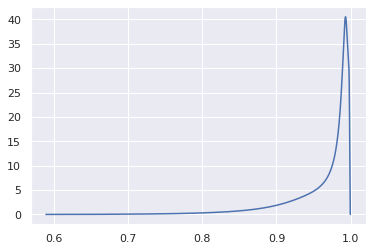

In [193]:
tf.random.set_seed(1)
np.random.seed(1)
layer = VimltsLinear(1,
                     activation=tfp.bijectors.Sigmoid(low=1e-9, high=1.-1e-9),
                     alpha_w=alpha_init[0],
                     beta_w=beta_init[0],
                     alpha_z=a_init[0],
                     beta_z=b_init[0],
                     theta=np.random.randn(50).astype(dtype=np.float32),
                     num_samples=10000,
                     prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta))
model = tf.keras.models.Sequential(layer, name='vimlts_linear')
model.build(input_shape=(None,1))
model.summary()

q, w = layer.get_w_dist()
q = q[:,0,0]
w = w[:,0,0]
bij = tfp.bijectors.Sigmoid()
pi = bij(w)
q_pi = tf.math.log(q) + bij.inverse_log_det_jacobian(pi, event_ndims=0)

plt.plot(pi, tf.math.exp(q_pi), label="VIMLTS")

In [194]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    # print(lr)
    return lr * tf.math.exp(-0.002)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

@tf.function
def nll(y_obs, y_pred):
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    # y_pred = tf.math.sigmoid(y_pred)
    dist = tfp.distributions.Bernoulli(probs=y_pred)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    # tf.print("nlls: ", tf.reduce_sum(nlls))
    return tf.reduce_sum(nlls)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05), loss=nll, run_eagerly=False)
tf.random.set_seed(2)
model.fit(tf.ones((len(data),1)), ytensor, epochs=2000, verbose=False, callbacks=[callback])

YES activation is Bijector
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
YES activation is Bijector


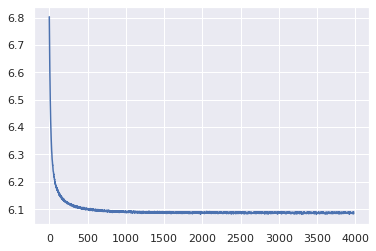

In [195]:
plt.plot(model.history.history['loss'][20:])

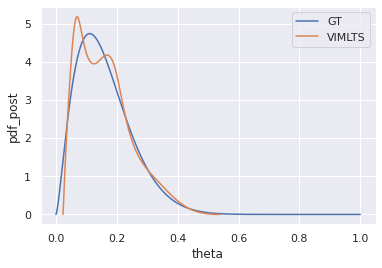

In [196]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_post=pdf_post, theta=thetas)), x='theta', y='pdf_post', label="GT")

q, w = layer.get_w_dist()
q = q[:,0,0]
w = w[:,0,0]
bij = tfp.bijectors.Sigmoid()
pi = bij(w)
q_pi = tf.math.log(q) + bij.inverse_log_det_jacobian(pi, event_ndims=0)

plt.plot(pi, tf.math.exp(q_pi), label="VIMLTS")
plt.legend()


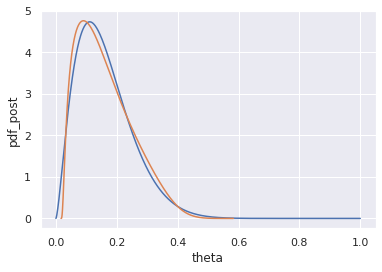

In [192]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_post=pdf_post, theta=thetas)), x='theta', y='pdf_post')

q, w = layer.get_w_dist()
q = q[:,0,0]
w = w[:,0,0]
bij = tfp.bijectors.Sigmoid()
pi = bij(w)
q_pi = tf.math.log(q) - bij.forward_log_det_jacobian(w, event_ndims=0)

plt.plot(pi, tf.math.exp(q_pi))


In [ ]:
np.trapz(tf.math.exp(q_pi), pi)

In [ ]:
bij.forward_log_det_jacobian(w, event_ndims=0)

In [ ]:
tf.reduce_mean(model(tf.ones((10,1))), 0)


































## With gradient instead of epsilon

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp



def init_beta_dist(M):
    in1 = []
    in2 = []
    for i in range(1,M+1):
        in1.append(i)
        in2.append(M-i+1)

    return tfd.Beta(in1,in2)

def init_beta_dist_dash(M):
    M=M-1
    in1 = []
    in2 = []
    for i in range(1,M+1):
        in1.append(i)
        in2.append(M-i+1)

    return tfd.Beta(in1,in2)

def eval_h_MLT(z,theta,beta_dist):
    if (z.shape==()):
        zI=z
        fIm=beta_dist.prob(zI)
        return tf.math.reduce_mean(fIm*theta)
    else:
        zI=tf.reshape(z,[-1,1])
        zI=tf.cast(zI, tf.float32)
        fIm=beta_dist.prob(zI)
        return tf.math.reduce_mean(fIm*theta,axis=1)

def eval_h_MLT_dash(z, theta, beta_dist_dash):
    len_koeff=theta.shape[0]
    zI=tf.reshape(z,[-1,1])
    zI=tf.cast(zI, tf.float32)

    by=beta_dist_dash.prob(zI)
    d_Theta=theta[1:len_koeff]-theta[0:(len_koeff-1)]

    bern_dash=tf.reduce_sum(by*d_Theta,axis=1)
    return bern_dash

@tf.function
def h_z2w(z, a, b, theta, alpha, beta, beta_dist):
    z_tilde=a*z-b
    z_sig=tf.math.sigmoid(z_tilde)
    h_MLT=eval_h_MLT(z=z_sig, theta=theta, beta_dist=beta_dist)
    w=alpha*h_MLT-beta
    return w

def h_w2z_black_box_inverse(w_to_inverse, a, b, theta, alpha, beta, beta_dist):
    z_optimized = tf.Variable(0.)

    a_not_trainable=a.numpy()
    b_not_trainable=b.numpy()
    theta_not_trainable=theta.numpy()
    alpha_not_trainable=alpha.numpy()
    beta_not_trainable=beta.numpy()

    loss_fn = lambda: (h_z2w(z=z_optimized,a=a_not_trainable,b=b_not_trainable,theta=theta_not_trainable,alpha=alpha_not_trainable,beta=beta_not_trainable,beta_dist=beta_dist) - w_to_inverse )**2
    tfp.math.minimize(loss_fn,
                    num_steps=30,
                    optimizer=tf.optimizers.Adam(learning_rate=0.1))
    return z_optimized

def h_w2z_fake_inverse_taylor(w_to_inverse, a, b, theta, alpha, beta, beta_dist, beta_dist_dash):
    m_plus_1=theta.shape[0]

    z=h_w2z_black_box_inverse(w_to_inverse=w_to_inverse,a=a,b=b,theta=theta,alpha=alpha,beta=beta,beta_dist=beta_dist)

    z_tilde=a*z-b
    z_sig=tf.math.sigmoid(z_tilde)

    taylor0=beta_dist.prob(z_sig)
    taylor1=theta.shape[0]*(0-beta_dist_dash.prob(z_sig)[0:1])
    for i in range(theta.shape[0]-2):
        taylor1=tf.concat((taylor1,(theta.shape[0]*(beta_dist_dash.prob(z_sig)[i:i+1]-beta_dist_dash.prob(z_sig)[i+1:i+2]))),axis=0)
    taylor1=tf.concat((taylor1,(theta.shape[0]*(beta_dist_dash.prob(z_sig)[theta.shape[0]-2:theta.shape[0]-1]))),axis=0)

    z_sig_fake=(((w_to_inverse+beta)/alpha)*m_plus_1-tf.reduce_sum(taylor0*theta))/tf.reduce_sum(taylor1*theta)+z_sig

    arg_log=1/z_sig_fake-1
    z_fake=(-tf.math.log(arg_log)+b)/a

    return z_fake

# @tf.function
# def eval_variational_dist(z, z_epsilon, a, b, theta, alpha, beta, beta_dist, beta_dist_dash):
#     fz=tfd.Normal(loc=0,scale=1).prob(z)
#     w=h_z2w(z=z,a=a,b=b,theta=theta,alpha=alpha,beta=beta,beta_dist=beta_dist)
#     w_epsilon=h_z2w(z=z_epsilon,a=a,b=b,theta=theta,alpha=alpha,beta=beta,beta_dist=beta_dist)
#     h_w2z_dash=(z_epsilon-z)/(w_epsilon-w)
#     q=fz*tf.math.abs(h_w2z_dash)
#     return q,w

def eval_variational_dist(z, z_epsilon, a, b, theta, alpha, beta, beta_dist, beta_dist_dash):
    fz=tfd.Normal(loc=0,scale=1).prob(z)
    with tf.GradientTape() as tape:
        tape.watch([z]) #Bug in TF? We need to watch z otherwise it does not work
        w=h_z2w(z=z,a=a,b=b,theta=theta,alpha=alpha,beta=beta,beta_dist=beta_dist)
        dw_dz = tape.gradient(w, z)
    h_w2z_dash = 1.0 / dw_dz
    q=fz*tf.math.abs(h_w2z_dash)
    return q,w

def to_a(a_tunable):
    return tf.math.softplus(a_tunable[0:1])

def to_theta(theta_tunable):
    theta=theta_tunable[0:1]
    for i in range(np.shape(theta_tunable)[0]-1):
        theta=tf.concat((theta,(theta[i:i+1]+tf.math.softplus(theta_tunable[i+1:i+2]))),axis=0)
    return theta

def to_alpha(alpha_tunable):
    return tf.math.softplus(alpha_tunable[0:1])

class no_epsVIMLTS:
    def __init__(self, m):
        self.m=m
        self.num_params=self.m+4
        self.beta_dist=init_beta_dist(self.m)
        self.beta_dist_dash=init_beta_dist_dash(self.m)

    def update_lambda_param(self, lambda_update):
        self.a_tilde=lambda_update[0:1]
        self.b=lambda_update[1:2]
        self.theta_delta=lambda_update[2:self.num_params-2]
        self.alpha_tilde=lambda_update[self.num_params-2:self.num_params-1]
        self.beta=lambda_update[self.num_params-1:self.num_params]

    def get_target_dist(self):
        zz=tf.Variable(np.linspace(-6,6,1000),dtype='float32')
        epsilon=tf.constant(0.001)
        z_epsilon=tf.Variable(zz+epsilon)
        q_dist,ww=eval_variational_dist(z=zz,z_epsilon=z_epsilon,a=to_a(self.a_tilde), b=self.b, theta=to_theta(self.theta_delta), alpha=to_alpha(self.alpha_tilde), beta=self.beta, beta_dist=self.beta_dist, beta_dist_dash=self.beta_dist_dash)
        return q_dist,ww

    def get_target_dist_for_z(self,z):
        epsilon=tf.constant(0.001)
        z_epsilon=tf.Variable(z+epsilon)
        q_dist,ww=eval_variational_dist(z=z,z_epsilon=z_epsilon,a=to_a(self.a_tilde), b=self.b, theta=to_theta(self.theta_delta), alpha=to_alpha(self.alpha_tilde), beta=self.beta, beta_dist=self.beta_dist, beta_dist_dash=self.beta_dist_dash)
        return q_dist, ww

    def get_sample_w(self):
        z_sample = tfd.Normal(loc=0., scale=1.).sample()
        return z_sample,h_z2w(z=z_sample, a=to_a(self.a_tilde), b=self.b, theta=to_theta(self.theta_delta), alpha=to_alpha(self.alpha_tilde), beta=self.beta, beta_dist=self.beta_dist)

    def get_h_mlt(self,overValues):
        return eval_h_MLT(z=overValues,theta=to_theta(self.theta_delta),beta_dist=self.beta_dist)

    def get_h_mlt_dash(self,overValues):
        return eval_h_MLT_dash(z=overValues,theta=to_theta(self.theta_delta),beta_dist_dash=self.beta_dist_dash)

    ##################################################### Debug functions ####################################################
    def get_beta(self,x):
        return self.beta_dist.prob(x)

    def get_beta_dash(self,x):
        return self.beta_dist_dash.prob(x)

    def get_param(self):
        param_array=to_a(self.a_tilde).numpy()
        param_array=np.concatenate((param_array,self.b.numpy()),axis=0)
        param_array=np.concatenate((param_array,to_theta(self.theta_delta).numpy()),axis=0)
        param_array=np.concatenate((param_array,to_alpha(self.alpha_tilde).numpy()),axis=0)
        param_array=np.concatenate((param_array,self.beta.numpy()),axis=0)
        return param_array

    def test_transformation(self,w_test):
        z_test=h_w2z_fake_inverse_taylor(w_to_inverse=w_test, a=to_a(self.a_tilde), b=self.b, theta=to_theta(self.theta_delta), alpha=to_alpha(self.alpha_tilde), beta=self.beta, beta_dist=self.beta_dist, beta_dist_dash=self.beta_dist_dash)
        print("ztest:",z_test)
        return h_z2w(z=z_test, a=to_a(self.a_tilde), b=self.b, theta=to_theta(self.theta_delta), alpha=to_alpha(self.alpha_tilde), beta=self.beta, beta_dist=self.beta_dist)

    def print_param(self):
        print("self.num_params:\t",self.num_params)
        print("self.a_tilde:\t\t",self.a_tilde.numpy())
        print("a:\t\t\t",to_a(self.a_tilde).numpy())
        print("self.b:\t\t\t",self.b.numpy())
        print("self.theta_delta:\t",self.theta_delta.numpy())
        print("theta:\t\t\t",to_theta(self.theta_delta).numpy())
        print("self.alpha_tilde:\t",self.alpha_tilde.numpy())
        print("alpha:\t\t\t",to_alpha(self.alpha_tilde).numpy())
        print("self.beta:\t\t",self.beta.numpy())

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)
# Number of epochs
epochs=400

# Number of samples psi to approximate the expected value
num_samples=10

# Learning rate
lr_start=0.08
lr_end=0.03

# Variational parameters init
a_init=(0.2,)
b_init=(0.,)
alpha_init = (np.log(np.exp(0.2) -1),)
beta_init = (0,)
# List to save the variational distribution during training
q_history=[]
# Prior
prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta)
ytensor = data.reshape(-1, 1)
ans=5
if(ans==6):
    # Using a high slope will help to find a mode that creates a bimodal fit
    delta_theta_high_slope_init = (-6,2.,-6.,-6.,-6.,8.,-6.,-6.,-6,3.)
    delta_theta_init=delta_theta_high_slope_init
else:
    delta_theta_gaussian_like_init = (-5,1.,0.8,0.8,0.6,0.4,0.2,0.2,1.,.0)
    delta_theta_init=delta_theta_gaussian_like_init
lambda_init=a_init+b_init+delta_theta_init+alpha_init+beta_init
num_lambda=np.shape(lambda_init)[0]
lambda_tunable = tf.Variable(lambda_init,dtype='float32')
# Instance of a variational distribution as VIMLTS
q_dist_no_eps=no_epsVIMLTS(np.shape(delta_theta_init)[0])
# Update the variational parameter to the variational distribution
q_dist_no_eps.update_lambda_param(lambda_tunable)

# Save the distribution to the history
q_history.append(q_dist_no_eps.get_target_dist())

# Logging
logger = Logger(epochs,num_weights=num_lambda)

In [ ]:
for hist in q_history:
    plt.plot(hist[1],hist[0])
plt.legend()
plt.grid()
plt.title(r'$q_{init}$')
plt.ylabel(r'$q(w)$')
plt.xlabel(r'$w$');

In [ ]:
for i in tqdm(range(epochs)):
    with tf.GradientTape() as tape:
        tape.watch([lambda_tunable])

        # Parameter update --------------------------------------------------
        q_dist_no_eps.update_lambda_param(lambda_tunable)

        # Iterarte over psi (number of samples)
        for current_sample in range(num_samples):
            # l_nll ------------------------------------------
            z_sample,w_sample_r=q_dist_no_eps.get_sample_w()
            w_sample = tf.math.sigmoid(w_sample_r)
            # Likelihood
            w_sample = tf.clip_by_value(w_sample, 1e-6, 1.-1e-6)
            y_prob = tfd.Bernoulli(probs=w_sample)
            # loss_nll
            l_nll_sample=-tf.reduce_sum(y_prob.log_prob(ytensor))
            l_nll_sample=tf.reshape(l_nll_sample,[-1])
            if current_sample==0:
                l_nll_list = l_nll_sample
            else:
                l_nll_list= tf.concat([l_nll_list,tf.reshape(l_nll_sample,[-1])],axis=0)


        # l_kl ------------------------------------------
            variational_dist_sample, _ =q_dist_no_eps.get_target_dist_for_z(z_sample) * 1 / (tf.exp(-w_sample_r) / (1+tf.math.exp(-w_sample_r)))
            prior_sample=prior_dist.prob(w_sample)
            l_kl_sample=kl_divergence(variational_dist_sample,prior_sample)
            l_kl_sample=tf.reshape(l_kl_sample,[-1])
            if current_sample==0:
                l_kl_list = l_kl_sample
            else:
                l_kl_list= tf.concat([l_kl_list,l_kl_sample],axis=0)


        l_nll=tf.reduce_mean(l_nll_list,axis=0)
        print("l_nll: ", l_nll)
        l_kl=tf.reduce_mean(l_kl_list,axis=0)
        print("l_kl: ", l_kl)

        # loss --------------------------------------
        loss = l_nll + l_kl

    grads = tape.gradient(loss,lambda_tunable)

    # Check for NaNs in gradient
    if True in tf.math.is_nan(grads):
        print("+++++++++NaN in gradient+++++++++++++")
        print("Parameter:", w_sample.numpy())
        print("Grads:",grads)
        continue

    # Save epoche to logger
    logger.log(i, i, lambda_tunable, grads, loss, l_kl, l_nll)

    # Update the variational parameter
    lr=get_lr(i)
    lambda_tunable = tf.Variable(lambda_tunable - lr*grads)


    # Prints and history
    if i % 10 == 0 or i < 10 or i==epochs-1:
        clear_output()
        print("\tloss \t", loss.numpy(),"\tl_nll\t",l_nll.numpy(),"\tl_kl\t",l_kl.numpy(), "\tlr ", lr)
        save_history=True
        if(save_history):
            q_history.append(q_dist_no_eps.get_target_dist())

In [ ]:
q_no, w_no = q_dist_no_eps.get_target_dist()
w_no = tf.math.sigmoid(w_no)
q_no = q_no / np.trapz(q_no, x=w) # normalize

alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_post=pdf_post, theta=thetas)), x='theta', y='pdf_post', label="Posterior")
plt.plot(w,q, label="VIMLTS")
plt.plot(w_no,q_no, label="VIMLTS_no_eps")
plt.legend()
plt.savefig("eps_vs_gradient.png")

# My VIMLTS

In [82]:
theta = np.array(delta_theta_init, dtype=np.float32)
layer = VimltsLinear(1, alpha_w=alpha_init[0], beta_w=beta_init[0], alpha_z=a_init[0], beta_z=b_init[0], theta=theta, num_samples=101)
model = tf.keras.models.Sequential(layer, name='vimlts_linear')
model.build(input_shape=(None,1))
model.summary()

@tf.function
def nll(y_obs, y_pred, sigma=1.):
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    return tf.reduce_sum(nlls)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=nll, run_eagerly=False)
model.fit(tf.ones((100,1)), tf.ones((100,1))*4, epochs=20)
# pred = model(tf.ones((5,1)))
# pred
# nll(tf.ones((5,1))*4, pred)

TypeError: __init__() missing 1 required positional argument: 'activation'

In [85]:
layer = VimltsLinear(1,
                     activation=tfp.bijectors.Sigmoid(low=1e-4, high=1.-1e-4),
                     alpha_w=alpha_init[0],
                     beta_w=beta_init[0],
                     alpha_z=a_init[0],
                     beta_z=b_init[0],
                     theta=theta,
                     num_samples=101,
                     prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta))
model = tf.keras.models.Sequential(layer, name='vimlts_linear')
model.build(input_shape=(None,1))
model.summary()

@tf.function
def nll(y_obs, y_pred):
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    # y_pred = tf.math.sigmoid(y_pred)
    dist = tfp.distributions.Bernoulli(probs=y_pred)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.print("nlls: ", tf.reduce_sum(nlls))
    return tf.reduce_sum(nlls)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=nll, run_eagerly=False)
model.fit(tf.ones((len(data),1)), tf.reshape(data, (-1,1)), epochs=20)

Model: "vimlts_linear"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_3 (VimltsLinea multiple                  14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
nlls:  17.6569862
1/1 [=================

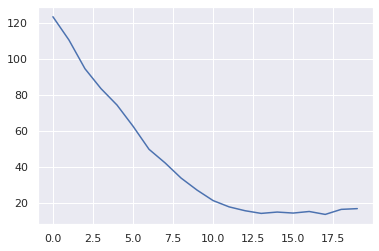

In [86]:
plt.plot(model.history.history['loss'])

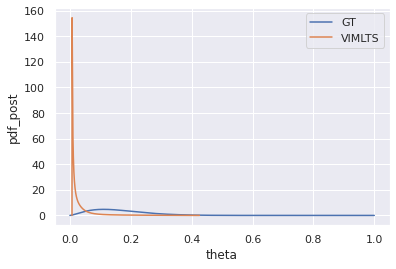

In [87]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_post=pdf_post, theta=thetas)), x='theta', y='pdf_post', label="GT")

q, w = layer.get_w_dist()
q = q.numpy().squeeze()
w = w.numpy().squeeze()
bij = tfp.bijectors.Sigmoid()
pi = bij(w)
q_pi = tf.math.log(q) + bij.inverse_log_det_jacobian(pi, event_ndims=0)

plt.plot(pi, tf.math.exp(q_pi), label="VIMLTS")
plt.legend()


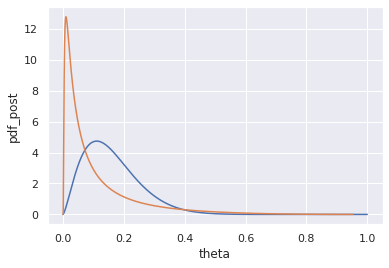

In [22]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=thetas)
sns.lineplot(data=pd.DataFrame.from_dict(dict(pdf_post=pdf_post, theta=thetas)), x='theta', y='pdf_post')

q, w = layer.get_w_dist()
q = q.numpy().squeeze()
w = w.numpy().squeeze()
bij = tfp.bijectors.Sigmoid()
pi = bij(w)
q_pi = tf.math.log(q) - bij.forward_log_det_jacobian(w, event_ndims=0)

plt.plot(pi, tf.math.exp(q_pi))


In [28]:
np.trapz(tf.math.exp(q_pi), pi)

1.000024

In [23]:
bij.forward_log_det_jacobian(w, event_ndims=0)

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([-7.5838056, -7.580967 , -7.5781126, -7.575244 , -7.5723596,
       -7.56946  , -7.566544 , -7.563614 , -7.5606694, -7.5577106,
       -7.5547323, -7.5517406, -7.548734 , -7.5457115, -7.542671 ,
       -7.5396175, -7.5365467, -7.5334597, -7.530356 , -7.527238 ,
       -7.524102 , -7.5209513, -7.5177836, -7.5146003, -7.511399 ,
       -7.508182 , -7.504947 , -7.501696 , -7.498429 , -7.495144 ,
       -7.491843 , -7.488523 , -7.485188 , -7.4818354, -7.4784646,
       -7.4750767, -7.4716716, -7.4682484, -7.4648094, -7.461351 ,
       -7.457874 , -7.4543796, -7.4508667, -7.4473386, -7.443791 ,
       -7.440224 , -7.4366407, -7.4330378, -7.429416 , -7.4257765,
       -7.4221196, -7.4184413, -7.414745 , -7.4110312, -7.407299 ,
       -7.4035463, -7.3997736, -7.395983 , -7.392173 , -7.3883424,
       -7.384495 , -7.380625 , -7.376737 , -7.3728294, -7.368903 ,
       -7.3649554, -7.3609877, -7.357    , -7.352992 , -7.348964 ,
       -7.344

In [20]:
tf.reduce_mean(model(tf.ones((10,1))), 0)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[3.855442],
       [3.855442],
       [3.855442],
       [3.855442],
       [3.855442],
       [3.855442],
       [3.855442],
       [3.855442],
       [3.855442],
       [3.855442]], dtype=float32)>

In [21]:
q, w = layer.get_w_dist()
q,w = q.numpy(), w.numpy()

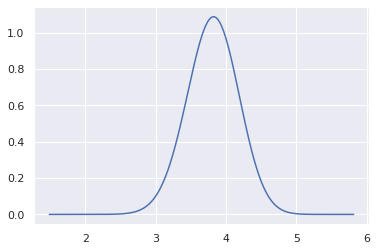

In [22]:
plt.plot(w.squeeze(), q.squeeze())

In [505]:
plt.plot(model.history.history['loss'])

AttributeError: 'NoneType' object has no attribute 'history'

In [21]:
bij = tfp.bijectors.Square()
z = tf.linspace(0,4,5)
print("z: ", z)
w = bij.forward(z)
print("w = z**2: ", w)
det_dW_dZ = tf.exp(bij.forward_log_det_jacobian(z, event_ndims=0))
det_dZ_dW = tf.exp(bij.inverse_log_det_jacobian(w, event_ndims=0))
print("dw/dz analytic: ", 2*z)
print("dw/dz bijector: ", det_dW_dZ)
print("dz/dw bijector: ", det_dZ_dW)
print("dz/dw bijector: ", 1/det_dW_dZ)
# bij.forward(tf.range(0,4,5))

z:  tf.Tensor([0. 1. 2. 3. 4.], shape=(5,), dtype=float64)
w = z**2:  tf.Tensor([ 0.  1.  4.  9. 16.], shape=(5,), dtype=float64)
dw/dz analytic:  tf.Tensor([0. 2. 4. 6. 8.], shape=(5,), dtype=float64)
dw/dz bijector:  tf.Tensor([0. 2. 4. 6. 8.], shape=(5,), dtype=float64)
dz/dw bijector:  tf.Tensor([       inf 0.5        0.25       0.16666667 0.125     ], shape=(5,), dtype=float64)
dz/dw bijector:  tf.Tensor([       inf 0.5        0.25       0.16666667 0.125     ], shape=(5,), dtype=float64)


In [22]:
bij(z)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 0.,  1.,  4.,  9., 16.])>